# Deep Learning Methods for Medical Image Analysis (CM2003)

# Laboratory Assignment 5: Part 1b

Lab Group 8:
- Gnana Spandana Akumalla
- Patrik Svensson
- Serkan Arda Yilal

In [1]:
# Import the required libraries
import os
import tensorflow as tf
import numpy as np
import cv2
import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, ZeroPadding2D, Activation, BatchNormalization, Input
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Conv2D, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt
from Utils import loss_dice_plot, loss_accuracy_plot, load_data, load_partial_data, load_image, load_mask, create_generator, image_mask_generator, binarize_mask, dice_coef
from Utils import dice_coef_loss, train_unet
from Models import conv_block, get_unet


### Preparing data and setting variables

In [2]:
# Define Constants and Paths
base= 8
img_width, img_height= 256, 256
batch_size = 8
learning_rate = 0.0001
epochs = 50
dropout = 0.2
batchnorm = True
metrics = [dice_coef, Precision(), Recall()] #Only dice_coef for task 1a 
verbose = 1
train_percentage=0.8

# Specifying augmentation generator 
generator = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True
    )

# Paths 
data_dir = 'Data/DL_course/Lab3/CT/'
image_dir = os.path.join(data_dir, 'Image/')
mask_dir = os.path.join(data_dir, 'Mask/')

# Load and preprocess images and masks. Only part of the dataset should be loaded because the kernel crashes otherwise
 # How many images to be loaded (dataset has >8000 images)
images, masks = load_partial_data(data_dir, image_dir, mask_dir, img_width, img_height, number_of_images=8000)

x_train, x_val, y_train, y_val = train_test_split(images, masks, test_size=1-train_percentage, random_state=42)
# Convert lists to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)

# Ensure that the shape of the data matches the model's input shape
x_train = x_train.reshape((-1, img_width, img_height, 1))
y_train = y_train.reshape((-1, img_width, img_height, 1))
x_val = x_val.reshape((-1, img_width, img_height, 1))
y_val = y_val.reshape((-1, img_width, img_height, 1))



load_partial_data: Printout to see that the images and labels are matched:
Data/DL_course/Lab3/CT/Image/Im0_64.png 	 --- 	  Data/DL_course/Lab3/CT/Mask/Im0_64_Mask.png
Data/DL_course/Lab3/CT/Image/Im0_65.png 	 --- 	  Data/DL_course/Lab3/CT/Mask/Im0_65_Mask.png
Data/DL_course/Lab3/CT/Image/Im0_66.png 	 --- 	  Data/DL_course/Lab3/CT/Mask/Im0_66_Mask.png
Data/DL_course/Lab3/CT/Image/Im0_67.png 	 --- 	  Data/DL_course/Lab3/CT/Mask/Im0_67_Mask.png
Data/DL_course/Lab3/CT/Image/Im0_68.png 	 --- 	  Data/DL_course/Lab3/CT/Mask/Im0_68_Mask.png
Data/DL_course/Lab3/CT/Image/Im0_69.png 	 --- 	  Data/DL_course/Lab3/CT/Mask/Im0_69_Mask.png
Data/DL_course/Lab3/CT/Image/Im0_70.png 	 --- 	  Data/DL_course/Lab3/CT/Mask/Im0_70_Mask.png
Data/DL_course/Lab3/CT/Image/Im0_71.png 	 --- 	  Data/DL_course/Lab3/CT/Mask/Im0_71_Mask.png
Data/DL_course/Lab3/CT/Image/Im0_72.png 	 --- 	  Data/DL_course/Lab3/CT/Mask/Im0_72_Mask.png
Data/DL_course/Lab3/CT/Image/Im0_73.png 	 --- 	  Data/DL_course/Lab3/CT/Mask/Im0_73_Mask

KeyboardInterrupt: 

## Data inspection
Left side in the masks (yellow) has the value 0.98431373 and right side (blue) has value 0.61176471. Background is 0.

In [ ]:
for inspect_img in range(0,24,2):
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
    ax1.imshow(x_train[inspect_img])
    ax2.imshow(y_train[inspect_img])
    ax3.imshow(x_train[inspect_img+1])
    ax4.imshow(y_train[inspect_img+1])

    plt.show()



# Binarization of masks
Creates two datasets with binary images, one for left lung and one for right (each with training and validation portion), where a pixel value of 1 represents the lung, and 0 represents no lung. 

Takes approx. 60 sec to perform on 100 images.

Time to binarize with dataset of 800 images: 670 seconds


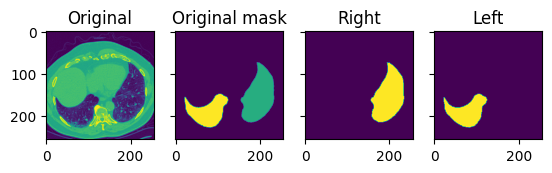

In [7]:
t0=time.time()

#Left lung
y_train_left=binarize_mask(y_train.copy(), img_height, img_width, val_lower=0.9, val_upper=1)
y_val_left=binarize_mask(y_val.copy(), img_height, img_width, val_lower=0.9, val_upper=1)

#Right lung
y_train_right=binarize_mask(y_train.copy(), img_height, img_width, val_lower=0.5, val_upper=0.7)
y_val_right=binarize_mask(y_val.copy(), img_height, img_width, val_lower=0.5, val_upper=0.7)

t1=time.time()
print("Time to binarize with dataset of", len(y_train_left),"images:", round((t1-t0)/60,2), "minutes")




# For inspection
inspect_img=1

f, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4, sharey=True)
ax1.imshow(x_train[inspect_img])
ax2.imshow(y_train[inspect_img])
ax3.imshow(y_train_right[inspect_img])
ax4.imshow(y_train_left[inspect_img])
ax1.set_title('Original')
ax2.set_title('Original mask')
ax3.set_title('Right')
ax4.set_title('Left')
plt.show()            

# Left lung model

Takes approx. 8 minutes when using a total of 1000 images and 50 epochs.

Epoch 1/50


/home/group_8/Utils.py:322: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator = train_image_mask_generator,steps_per_epoch = step_size_train,


100/100 [==============================] - 15s 106ms/step - loss: -0.2364 - dice_coef: 0.2364 - precision: 0.1449 - recall: 0.8949 - val_loss: -0.2211 - val_dice_coef: 0.2211 - val_precision: 0.1447 - val_recall: 0.9910
Epoch 2/50
100/100 [==============================] - 9s 94ms/step - loss: -0.2666 - dice_coef: 0.2666 - precision: 0.1851 - recall: 0.9011 - val_loss: -0.2174 - val_dice_coef: 0.2174 - val_precision: 0.1419 - val_recall: 0.1192
Epoch 3/50
100/100 [==============================] - 9s 95ms/step - loss: -0.2945 - dice_coef: 0.2945 - precision: 0.2345 - recall: 0.8701 - val_loss: -0.2136 - val_dice_coef: 0.2136 - val_precision: 0.0599 - val_recall: 3.1821e-04
Epoch 4/50
100/100 [==============================] - 9s 94ms/step - loss: -0.3064 - dice_coef: 0.3064 - precision: 0.2598 - recall: 0.8466 - val_loss: -0.1993 - val_dice_coef: 0.1993 - val_precision: 0.0546 - val_recall: 1.5192e-05
Epoch 5/50
100/100 [==============================] - 10s 96ms/step - loss: -0.3140 -

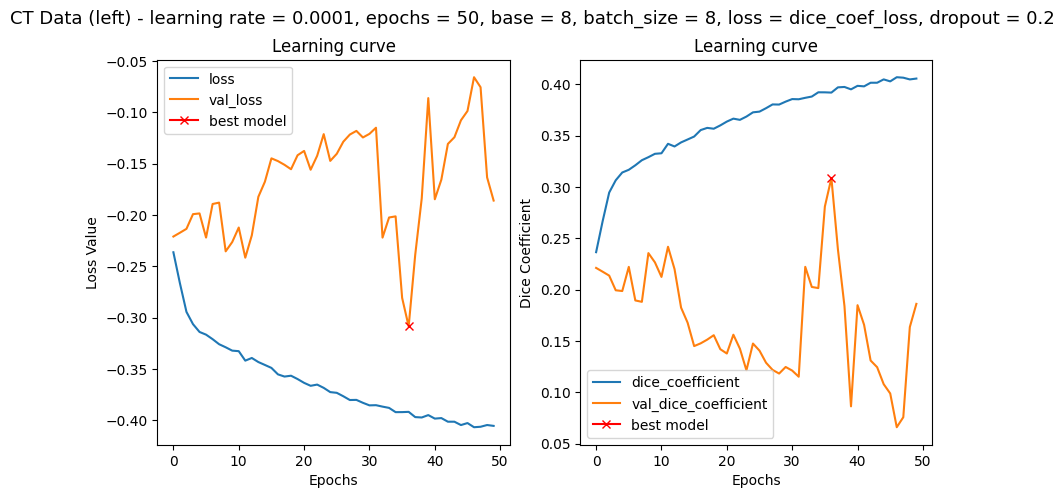

Time to train with 800 training images and 50 epochs: 474 seconds


In [8]:
loss = [dice_coef_loss]

model_dice_drop_left = get_unet(input_shape=(img_width, img_height, 1), base = base, batchnorm=batchnorm, dropout = dropout)
t2=time.time()

model_dice_drop_left, history_dice_drop_left = train_unet(model_dice_drop_left, x_train, y_train_left, x_val, y_val_left, batch_size, epochs, 
                                                learning_rate,
                                                metrics, verbose = verbose,
                                               loss = loss, generator=generator)
t3=time.time()


loss_dice_plot(history_dice_drop_left, "CT Data (left) - learning rate = {}, epochs = {}, base = {}, batch_size = {}, loss = dice_coef_loss, dropout = {}".format(learning_rate, epochs,
                                                                                                base,batch_size, dropout))


print("Time to train with" ,len(y_train_left), "training images and", epochs ,"epochs:", round((t3-t2)/60,2), "minutes")

### Model prediction inspection

7/7 [==============================] - 1s 22ms/step


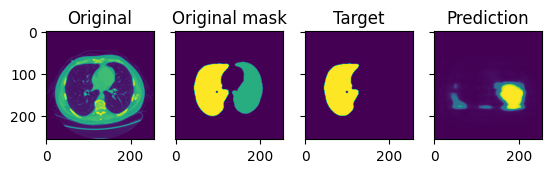

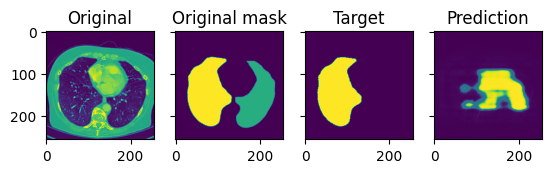

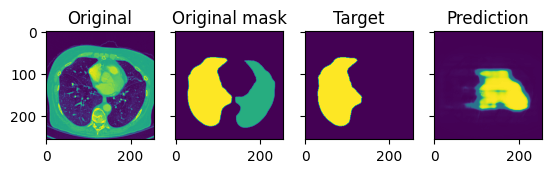

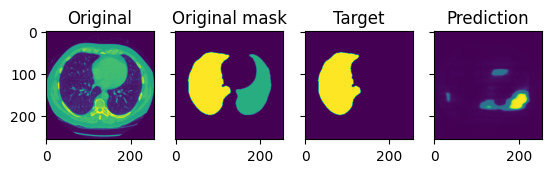

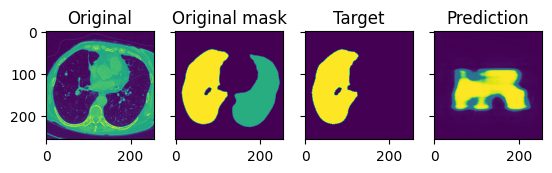

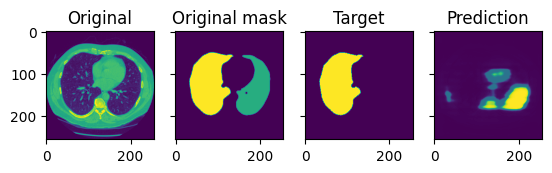

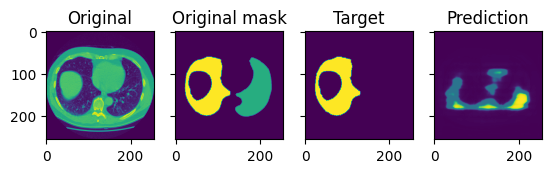

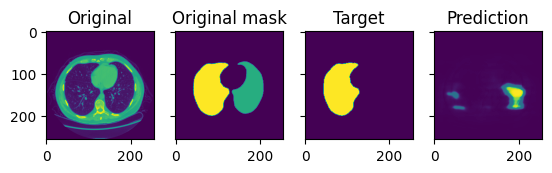

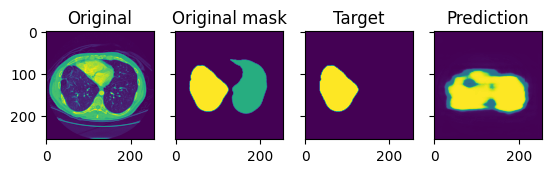

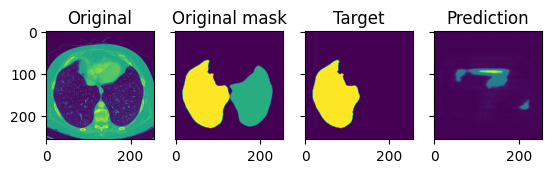

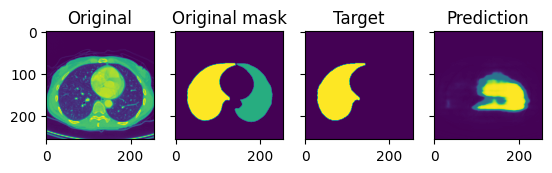

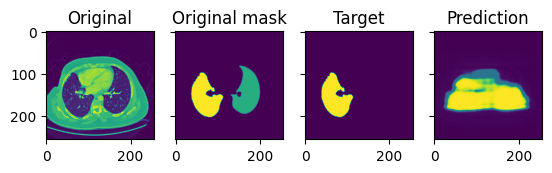

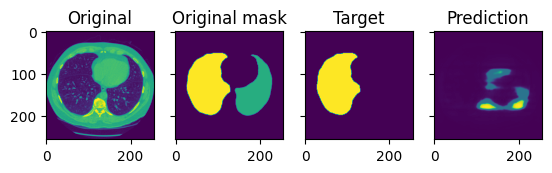

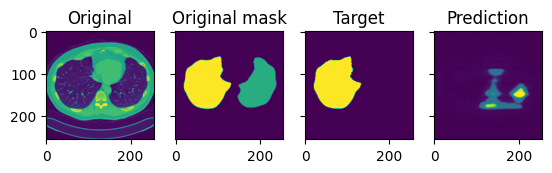

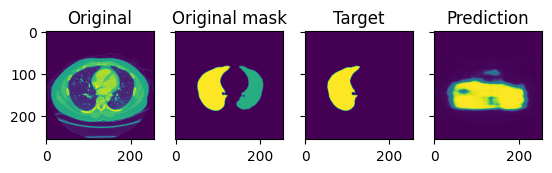

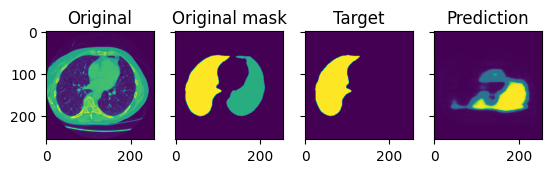

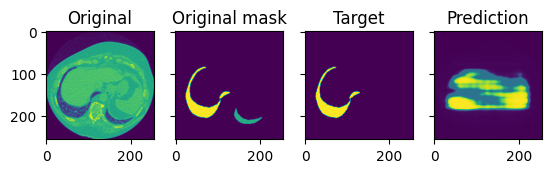

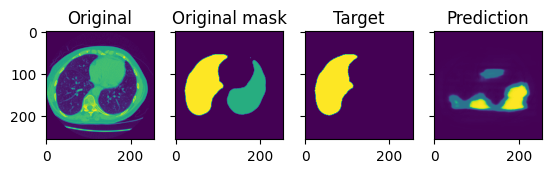

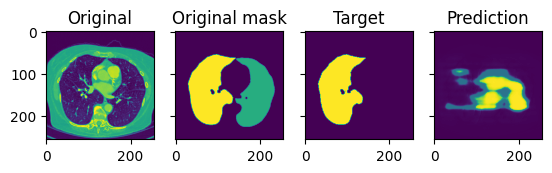

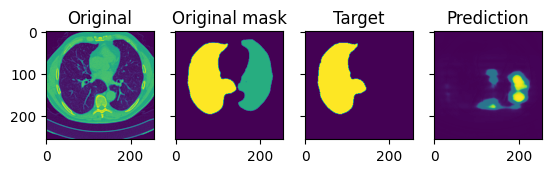

In [9]:
predictions_left=model_dice_drop_left.predict(x_val)


for inspect_img in range(0,20):
    f, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4, sharey=True)
    ax1.imshow(x_val[inspect_img])
    ax2.imshow(y_val[inspect_img])
    ax3.imshow(y_val_left[inspect_img])
    ax4.imshow(predictions_left[inspect_img])
    ax1.set_title('Original')
    ax2.set_title('Original mask')
    ax3.set_title('Target')
    ax4.set_title('Prediction')
    plt.show()     


# Right lung model

In [10]:
# Define Constants and Paths for right lung 
base= 8
img_width, img_height= 256, 256
batch_size = 8
learning_rate = 0.0001
epochs = 50
dropout = 0.2
batchnorm = True
metrics = [dice_coef, Precision(), Recall()] #Only dice_coef for task 1a 
verbose = 1
train_percentage=0.8

Epoch 1/50
100/100 [==============================] - 13s 102ms/step - loss: -0.1952 - dice_coef: 0.1952 - precision_1: 0.1134 - recall_1: 0.9797 - val_loss: -0.1781 - val_dice_coef: 0.1781 - val_precision_1: 0.1082 - val_recall_1: 1.0000
Epoch 2/50
100/100 [==============================] - 9s 94ms/step - loss: -0.1989 - dice_coef: 0.1989 - precision_1: 0.1142 - recall_1: 0.9812 - val_loss: -0.1833 - val_dice_coef: 0.1833 - val_precision_1: 0.1098 - val_recall_1: 1.0000
Epoch 3/50
100/100 [==============================] - 10s 96ms/step - loss: -0.2002 - dice_coef: 0.2002 - precision_1: 0.1133 - recall_1: 0.9811 - val_loss: -0.1883 - val_dice_coef: 0.1883 - val_precision_1: 0.1100 - val_recall_1: 1.0000
Epoch 4/50
100/100 [==============================] - 9s 95ms/step - loss: -0.2045 - dice_coef: 0.2045 - precision_1: 0.1153 - recall_1: 0.9779 - val_loss: -0.1961 - val_dice_coef: 0.1961 - val_precision_1: 0.1105 - val_recall_1: 0.9998
Epoch 5/50
100/100 [=============================

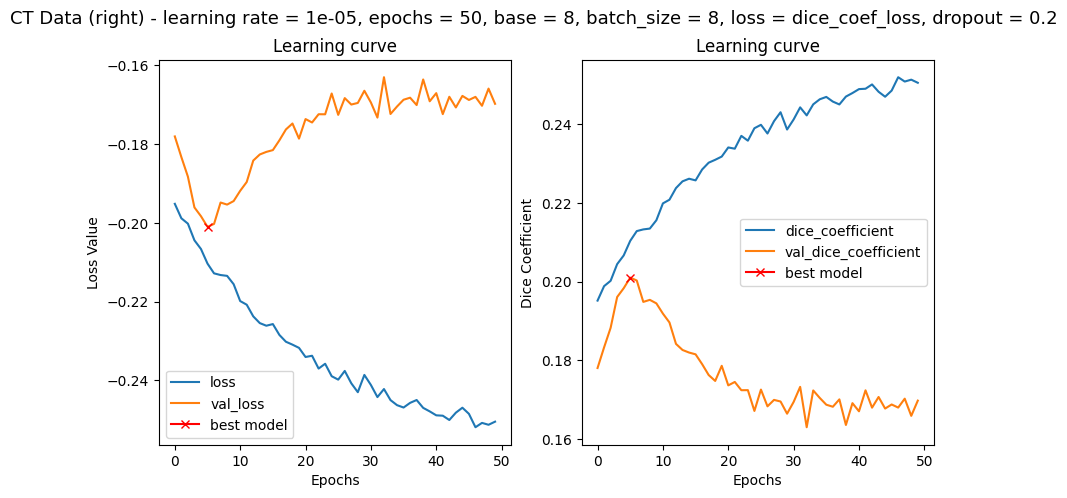

In [11]:
loss = [dice_coef_loss]

model_dice_drop_right = get_unet(input_shape=(img_width, img_height, 1), base = base, batchnorm=batchnorm, dropout = dropout)

model_dice_drop_right, history_dice_drop_right = train_unet(model_dice_drop_right, x_train, y_train_right, x_val, y_val_right, batch_size, epochs, 
                                                learning_rate,
                                               metrics, verbose = verbose,
                                               loss = loss, generator=generator)

loss_dice_plot(history_dice_drop_right, "CT Data (right) - learning rate = {}, epochs = {}, base = {}, batch_size = {}, loss = dice_coef_loss, dropout = {}".format(learning_rate, epochs,
                                                                                                base,batch_size, dropout))


### Model prediction inspection

7/7 [==============================] - 1s 28ms/step


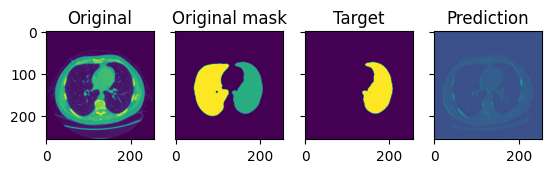

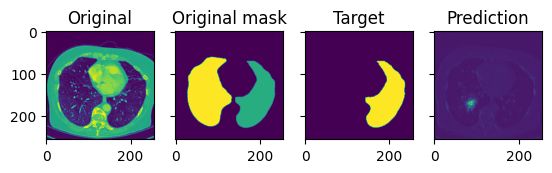

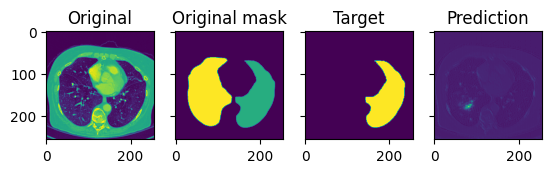

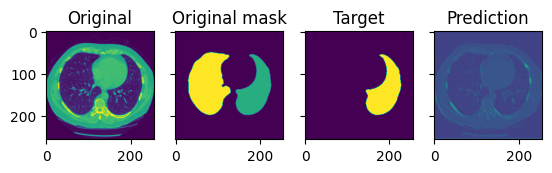

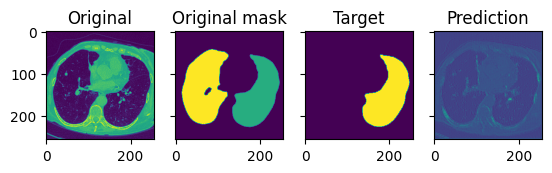

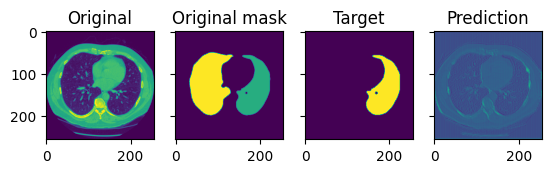

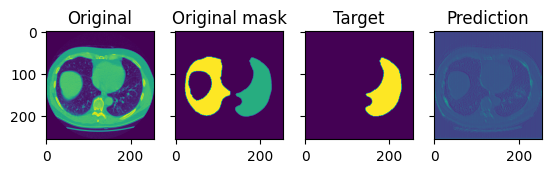

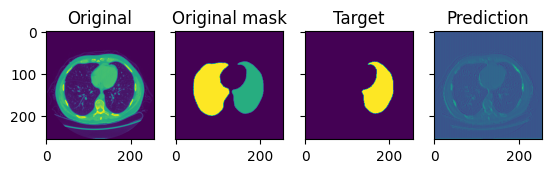

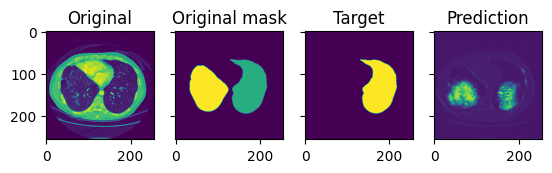

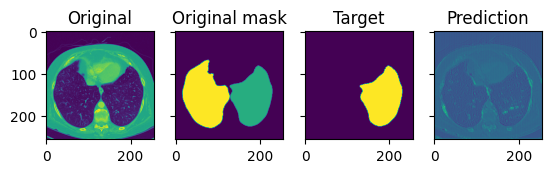

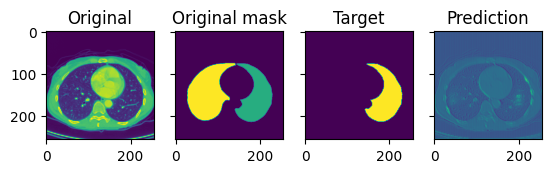

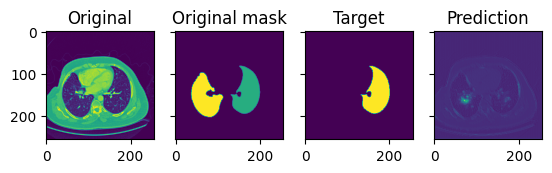

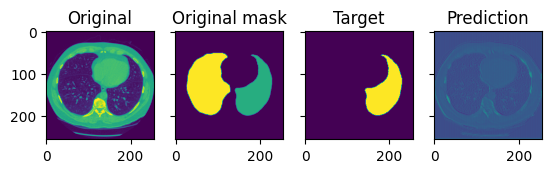

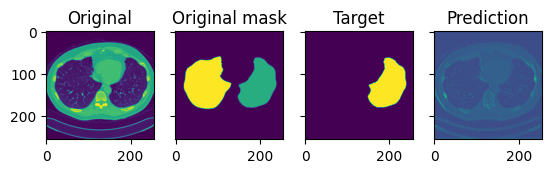

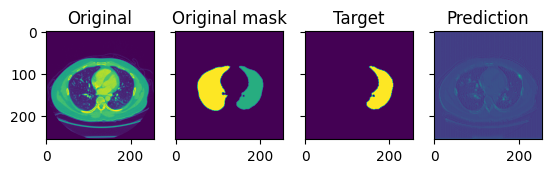

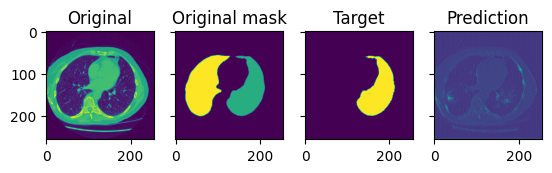

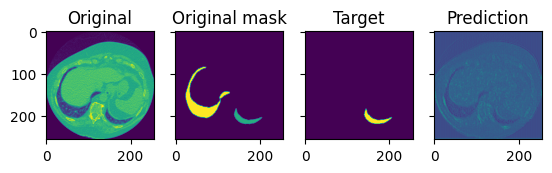

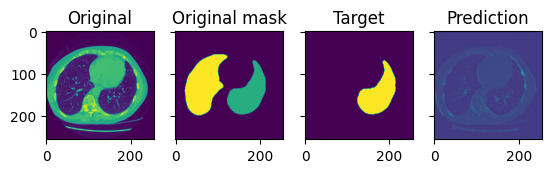

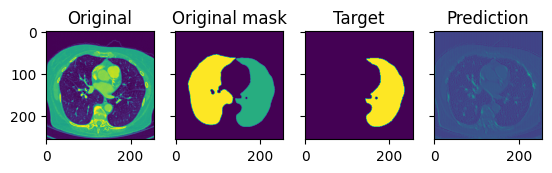

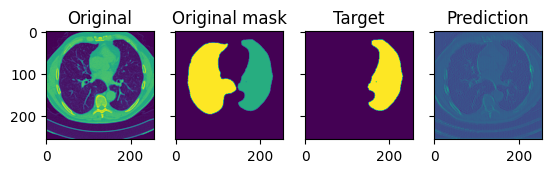

In [12]:
predictions_right=model_dice_drop_right.predict(x_val)

for inspect_img in range(0,20):
    f, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4, sharey=True)
    ax1.imshow(x_val[inspect_img])
    ax2.imshow(y_val[inspect_img])
    ax3.imshow(y_val_right[inspect_img])
    ax4.imshow(predictions_right[inspect_img])
    ax1.set_title('Original')
    ax2.set_title('Original mask')
    ax3.set_title('Target')
    ax4.set_title('Prediction')
    plt.show()     

### Task 1b: What can be inferred from precision and recall metrics?
Precision tells us what proportion of positive identifications was actually correct, so in this case it tells us how big proportion of predicted yellow pixels were actually part of the target mask. From this we can infer how good the model is at avoiding false positives. A low precision value means more false positives. 

Recall tells us how much of the actual positives that were classified as such. It gives an insight in how good the model is at correctily predicting positive values and avoiding predicting false negatives. A low recall value means more false negatives. 
